# HEC-RAS 1D HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze HEC-RAS 2D HDF data using the ras-commander library. It leverages the HdfBase, HdfUtils, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, and HdfResultsXsec classes to streamline data extraction, processing, and visualization.


In [49]:
# Import required Libraries
import subprocess
import sys
import os
from pathlib import Path

def install_module(module_name):
    try:
        __import__(module_name)
    except ImportError:
        print(f"{module_name} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", module_name])

# List of modules to check and install if necessary
modules = ['h5py', 'numpy', 'requests', 'geopandas', 'matplotlib', 'pandas', 'pyproj', 'shapely', 'xarray','rtree']
for module in modules:
    install_module(module)

# Import the rest of the required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point, LineString, Polygon
import xarray as xr


In [50]:
# Install ras-commander if you are not in a dev environment. 
# install_module(ras-commander)

## Importing ras-commander flexibly (from package or local dev copy)

In [ ]:
import sys
from pathlib import Path

# Flexible imports to allow for development without installation 
#  ** Use this version with Jupyter Notebooks **
try:
    # Try to import from the installed package
    from ras_commander import (init_ras_project, HdfBase, HdfUtils, HdfFluvialPluvial, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, HdfResultsXsec, HdfPipe, HdfPump, RasExamples, RasCmdr, RasPlan, RasGeo, RasUnsteady, RasUtils, RasPrj, RasGpt, ras)
    from ras_commander.Decorators import standardize_input, log_call
    from ras_commander.LoggingConfig import setup_logging, get_logger
except ImportError:
    # If the import fails, add the parent directory to the Python path
    import os
    current_file = Path(os.getcwd()).resolve()
    parent_directory = current_file.parent
    sys.path.append(str(parent_directory))
    
    # Now try to import again
    from ras_commander import (init_ras_project, HdfBase, HdfUtils, HdfFluvialPluvial, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, HdfResultsXsec, HdfPipe, HdfPump, RasExamples, RasCmdr, RasPlan, RasGeo, RasUnsteady, RasUtils, RasPrj, RasGpt, ras)
    from ras_commander.Decorators import standardize_input, log_call
    from ras_commander.LoggingConfig import setup_logging, get_logger

print("ras_commander imported successfully")

In [ ]:
# Download the BaldEagleCrkMulti2D project from HEC and run plan 01

# Define the path to the BaldEagleCrkMulti2D project
current_dir = Path.cwd()  # Adjust if your notebook is in a different directory
bald_eagle_path = current_dir / "example_projects" / "Balde Eagle Creek"
import logging

# Check if BaldEagleCrkMulti2D.p06.hdf exists (so we don't have to re-run the simulation when re-running or debugging)
hdf_file = bald_eagle_path / "BaldEagle.p01.hdf"

if not hdf_file.exists():
    # Initialize RasExamples and extract the BaldEagleCrkMulti2D project
    ras_examples = RasExamples()
    ras_examples.extract_project(["Balde Eagle Creek"])

    # Initialize custom Ras object
    bald_eagle = RasPrj()

    # Initialize the RAS project using the custom ras object
    bald_eagle = init_ras_project(bald_eagle_path, "6.6", ras_instance=bald_eagle)
    logging.info(f"Balde Eagle project initialized with folder: {bald_eagle.project_folder}")
    
    logging.info(f"Balde Eagle object id: {id(bald_eagle)}")
    
    # Define the plan number to execute
    plan_number = "01"

    # Execute Plan 06 using RasCmdr for Bald Eagle
    print(f"Executing Plan {plan_number} for the Bald Eagle Creek project...")
    success_bald_eagle = RasCmdr.compute_plan(plan_number, ras_object=bald_eagle)
    if success_bald_eagle:
        print(f"Plan {plan_number} executed successfully for Bald Eagle.\n")
    else:
        print(f"Plan {plan_number} execution failed for Bald Eagle.\n")
else:
    print("BaldEagle.p01.hdf already exists. Skipping project extraction and plan execution.")
    # Initialize the RAS project using the custom ras object
    bald_eagle = RasPrj()
    bald_eagle = init_ras_project(bald_eagle_path, "6.6", ras_instance=bald_eagle)
    plan_number = "01"

In [ ]:
# Load Plan and Geometry Dataframes and find Plan and Geometry HDF Paths

# Display plan_df for bald_eagle project
print("Plan DataFrame for bald_eagle project:")
display(bald_eagle.plan_df)

# Display geom_df for bald_eagle project
print("\nGeometry DataFrame for bald_eagle project:")
display(bald_eagle.geom_df)

# Get the plan HDF path
plan_number = "01"  # Assuming we're using plan 01 as in the previous code
plan_hdf_path = bald_eagle.plan_df.loc[bald_eagle.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

# Get the geometry file number from the plan DataFrame
geom_file = bald_eagle.plan_df.loc[bald_eagle.plan_df['plan_number'] == plan_number, 'Geom File'].values[0]
geom_number = geom_file[1:]  # Remove the 'g' prefix

# Get the geometry HDF path
geom_hdf_path = bald_eagle.geom_df.loc[bald_eagle.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]

print(f"\nPlan HDF path for Plan {plan_number}: {plan_hdf_path}")
print(f"Geometry HDF path for Plan {plan_number}: {geom_hdf_path}")

-----

RasHdfUtils
| Method Name | Description |
|-------------|-------------|
| get_attrs | Converts attributes from a HEC-RAS HDF file into a Python dictionary for a given attribute path |
| get_root_attrs | Returns attributes at root level of HEC-RAS HDF file |
| get_hdf_paths_with_properties | Gets all paths in the HDF file with their properties |
| get_group_attributes_as_df | Gets attributes of a group in the HDF file as a DataFrame |
| get_hdf_filename | Gets the HDF filename from various input types |
| get_runtime_data | Extracts runtime and compute time data from a single HDF file |


In [ ]:
# Get HDF Paths with Properties (For Exploring HDF Files)
hdf_paths_df = HdfUtils.get_hdf_paths_with_properties(plan_number, ras_object=bald_eagle)
display(hdf_paths_df.head())

In [ ]:
# Example: Extract runtime and compute time data
print("\nExample 2: Extracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_input=plan_number, ras_object=bald_eagle)
if runtime_df is not None:
    display(runtime_df)
else:
    print("No runtime data found.")

Table of all the functions in the RasGeomHdf class from the ras_commander/RasGeomHdf.py file:

| Function Name | Description |
|---------------|-------------|
| projection | Returns the projection of the RAS geometry as a pyproj.CRS object |
| get_geom_attrs | Returns base geometry attributes from a HEC-RAS HDF file |

| mesh_area_names | Returns a list of the 2D mesh area names of the RAS geometry |
| get_geom_2d_flow_area_attrs | Returns geometry 2d flow area attributes from a HEC-RAS HDF file |
| mesh_areas | Returns 2D flow area perimeter polygons |
| mesh_cell_polygons | Returns 2D flow mesh cell polygons |
| mesh_cell_points | Returns 2D flow mesh cell points |
| mesh_cell_faces | Returns 2D flow mesh cell faces |

| get_geom_structures_attrs | Returns geometry structures attributes from a HEC-RAS HDF file |




| bc_lines | Returns 2D mesh area boundary condition lines |
| breaklines | Returns 2D mesh area breaklines |



| refinement_regions | Returns 2D mesh area refinement regions |
| structures | Returns the model structures |
| reference_lines_names | Returns reference line names |
| reference_points_names | Returns reference point names |
| reference_lines | Returns the reference lines geometry and attributes |
| reference_points | Returns the reference points geometry and attributes |
| cross_sections | Returns the model 1D cross sections |
| river_reaches | Returns the model 1D river reach lines |
| cross_sections_elevations | Returns the model cross section elevation information |

In [ ]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 06 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

In [ ]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfUtils.projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.")

In [ ]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Base Geometry Attributes")
geom_attrs = HdfPlan.get_geom_attrs(geom_hdf_path, ras_object=bald_eagle)

if geom_attrs:
    # Convert the dictionary to a DataFrame for better display
    geom_attrs_df = pd.DataFrame([geom_attrs])
    
    # Display the DataFrame
    print("Base Geometry Attributes:")
    display(geom_attrs_df)
else:
    print("No base geometry attributes found.")


In [ ]:
# Use HdfMesh for geometry-related operations
print("\nExample 3: Listing 2D Flow Area Names")
flow_area_names = HdfMesh.mesh_area_names(geom_hdf_path, ras_object=bald_eagle)
print("2D Flow Area Names:", flow_area_names)

In [ ]:
# Get geometry structures attributes
print("\nGetting geometry structures attributes")
geom_structures_attrs = HdfStruc.get_geom_structures_attrs(geom_hdf_path, ras_object=bald_eagle)
if geom_structures_attrs:
    print("Geometry structures attributes:")
    for key, value in geom_structures_attrs.items():
        print(f"{key}: {value}")
else:
    print("No geometry structures attributes found.")

In [61]:
# TODO: Paths and Functions for each type of structure: 

# Getting geometry structures attributes
# Geometry structures attributes:
# Bridge/Culvert Count: 0
# Connection Count: 4
# Has Bridge Opening (2D): 0
# Inline Structure Count: 0
# Lateral Structure Count: 0

### NEED TO EDIT THIS TO SHOW BC LINES WITH RIVERS AND CROSS SECTIONS

# Example: Extract Boundary Condition Lines and Plot with 2D Flow Area Perimeter Polygons
print("\nExample 7: Extracting Boundary Condition Lines and Plotting with 2D Flow Area Perimeter Polygons")
bc_lines_df = HdfBndry.bc_lines(geom_hdf_path, ras_object=bald_eagle)
if not bc_lines_df.empty:
    display(bc_lines_df.head())
else:
    print("No Boundary Condition Lines found.")

# Plot if data exists
if not bc_lines_df.empty or not mesh_areas.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot 2D Flow Area Perimeter Polygons
    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')
    
    # Plot boundary condition lines
    if not bc_lines_df.empty:
        bc_lines_df.plot(ax=ax, color='red', linewidth=2, label='Boundary Condition Lines')
    
    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Boundary Condition Lines')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

In [62]:
# INSTEAD OF hdf_input, USE plan_hdf_path or geom_hdf_path as appropriate 

In [ ]:
# Example: Get structures
structures_gdf = HdfStruc.structures(geom_hdf_path, ras_object=bald_eagle)
print("Structures:")
if not structures_gdf.empty:
    display(structures_gdf.head())
else:
    print("No structures found in the geometry file.")

In [ ]:
# Example: Get reference line names
ref_line_names = HdfBndry.reference_lines_names(geom_hdf_path, ras_object=bald_eagle)
print("\nReference Line Names:")
print(ref_line_names)

In [ ]:
# Example: Get reference point names
ref_point_names = HdfBndry.reference_points_names(geom_hdf_path, ras_object=bald_eagle)
print("\nReference Point Names:")
print(ref_point_names)

In [ ]:
# Example: Get reference lines
ref_lines_gdf = HdfBndry.reference_lines(geom_hdf_path, ras_object=bald_eagle)
print("\nReference Lines:")
if not ref_lines_gdf.empty:
    display(ref_lines_gdf.head())
else:
    print("No reference lines found in the geometry file.")

In [ ]:
# Example: Get reference points
ref_points_gdf = HdfBndry.reference_points(geom_hdf_path, ras_object=bald_eagle)
print("\nReference Points:")
if not ref_points_gdf.empty:
    display(ref_points_gdf.head())
else:
    print("No reference points found in the geometry file.")

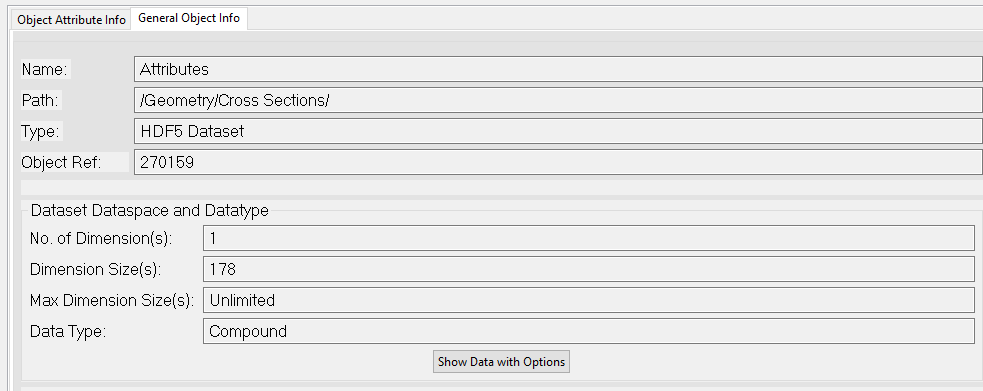

In [ ]:
# Recursively explore the Cross Sections structure in the geometry HDF file
import h5py
def print_hdf_structure(name, obj):
    """Print information about HDF5 object"""
    print(f"\nPath: {name}")
    print(f"Type: {type(obj).__name__}")
    
    if isinstance(obj, h5py.Dataset):
        print(f"Shape: {obj.shape}")
        print(f"Dtype: {obj.dtype}")
        print("Attributes:")
        for key, value in obj.attrs.items():
            print(f"  {key}: {value}")

def explore_cross_sections(file_path):
    """
    Recursively explore and print Cross Sections structure in HDF5 file
    
    :param file_path: Path to the HDF5 file
    """
    try:
        with h5py.File(file_path, 'r') as hdf_file:
            if '/Geometry/Cross Sections' in hdf_file:
                xs_group = hdf_file['/Geometry/Cross Sections']
                xs_group.visititems(print_hdf_structure)
            else:
                print("Cross Sections group not found in geometry file")
    except Exception as e:
        print(f"Error exploring HDF file: {e}")

print("\nExploring Cross Sections structure in geometry file:")
print("HDF Base Path: /Geometry/Cross Sections ")
explore_cross_sections(geom_hdf_path)


In [ ]:
# Example: Get cross section geodataframe
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)
with pd.option_context('display.max_columns', None):  # Show all columns
    display(cross_sections_gdf)

cross_sections_gdf: 

| geometry | station_elevation | mannings_n | ineffective_blocks | River | Reach | RS | Name | Description | Len Left | Len Channel | Len Right | Left Bank | Right Bank | Friction Mode | Contr | Expan | Left Levee Sta | Left Levee Elev | Right Levee Sta | Right Levee Elev | HP Count | HP Start Elev | HP Vert Incr | HP LOB Slices | HP Chan Slices | HP ROB Slices | Ineff Block Mode | Obstr Block Mode | Default Centerline | Last Edited |
|-----------|-------------------|------------|--------------------|-------|-------|----|------|-------------|----------|-------------|-----------|-----------|------------|----------------|-------|-------|----------------|-----------------|----------------|------------------|----------|----------------|---------------|----------------|----------------|----------------|------------------|------------------|-------------------|--------------|
| 0         | LINESTRING (1968668.17 290166.79, 1969067.87 2... | [[0.0, 660.41], [5.0, 660.61], [40.0, 659.85],... | {'Station': [0.0, 190.0, 375.0], 'Mann n': [0.... | []    | Bald Eagle | Loc Hav | 138154.4 |             | 358.429993 | 463.640015 | 517.640015 | 190.000000 | 375.000000 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 49       | 656.799988      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |
| 1         | LINESTRING (1968627.02 290584.12, 1969009.09 2... | [[0.0, 664.28], [50.0, 661.73], [55.0, 661.54]... | {'Station': [0.0, 535.0, 672.5599975585938], '... | []    | Bald Eagle | Loc Hav | 137690.8 |             | 305.709991 | 363.839996 | 382.829987 | 535.000000 | 672.559998 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 65       | 654.229980      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |
| 2         | LINESTRING (1968585.88 290854.5, 1968868.02 29... | [[0.0, 662.72], [20.0, 665.5], [25.0, 666.48],... | {'Station': [0.0, 580.0, 717.239990234375], 'M... | []    | Bald Eagle | Loc Hav | 137327.0 |             | 732.929993 | 762.020020 | 765.359985 | 580.000000 | 717.239990 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 66       | 653.900024      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |


In [ ]:
# Filter cross sections to show only those with ineffective blocks
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)

if not cross_sections_gdf.empty:
    # Filter rows where ineffective_blocks is not empty
    ineffective_xs = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(len) > 0]
    
    if not ineffective_xs.empty:
        print("\nCross Sections with Ineffective Flow Areas:")
        display(ineffective_xs)
    else:
        print("\nNo cross sections found with ineffective flow areas.")
else:
    print("No cross sections found in the geometry file.")


In [ ]:
# Get cross sections data
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)
print("\nCross Section Information:")
if not cross_sections_gdf.empty:
    for idx, row in cross_sections_gdf.iterrows():
        print(f"\nCross Section {idx + 1}:")
        print(f"River: {row['River']}")
        print(f"Reach: {row['Reach']}")
        print("\nGeometry:")
        print(row['geometry'])
        print("\nStation-Elevation Points:")
        
        # Print header
        print("     #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation")
        print("-" * 150)
        
        # Calculate number of rows needed
        points = row['station_elevation']
        num_rows = (len(points) + 4) // 5  # Round up division
        
        # Print points in 5 columns
        for i in range(num_rows):
            line = ""
            for j in range(5):
                point_idx = i + j * num_rows
                if point_idx < len(points):
                    station, elevation = points[point_idx]
                    line += f"{point_idx+1:6d} {station:10.2f} {elevation:10.2f}    "
            print(line)
        print("-" * 150)
else:
    print("No cross sections found in the geometry file.")


In [ ]:
# Plot cross sections on map
import matplotlib.pyplot as plt

# Get cross sections data
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)

if not cross_sections_gdf.empty:
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Plot cross sections
    cross_sections_gdf.plot(ax=ax, color='red', linewidth=1, label='Cross Sections')
    
    # Add river name and reach labels
    #for idx, row in cross_sections_gdf.iterrows():
    #    # Get midpoint of cross section line for label placement
    #    midpoint = row.geometry.centroid
    #    label = f"{row['River']}\n{row['Reach']}\nRS: {row['RS']}"
    #    ax.annotate(label, (midpoint.x, midpoint.y), 
    #               xytext=(5, 5), textcoords='offset points',
    #               fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    
    # Customize plot
    ax.set_title('Cross Sections Location Map')
    ax.grid(True)
    ax.legend()
    
    # Equal aspect ratio to preserve shape
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
else:
    print("No cross sections found in the geometry file.")



In [ ]:
# Plot cross sections with Manning's n values colored by value
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString

# Get cross sections data
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)

# Create figure
fig, ax1 = plt.subplots(figsize=(20,10))

# Create colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0.02, vmax=0.08)  # Typical Manning's n range

# Plot cross sections colored by Manning's n
for idx, row in cross_sections_gdf.iterrows():
    # Extract Manning's n values and stations
    mannings = row['mannings_n']
    n_values = mannings['Mann n']
    stations = mannings['Station']
    
    # Get the full linestring coordinates
    line_coords = list(row.geometry.coords)
    
    # Calculate total length of the cross section
    total_length = row.geometry.length
    
    # For each Manning's n segment
    for i in range(len(n_values)-1):
        # Calculate the start and end proportions along the line
        start_prop = stations[i] / stations[-1]
        end_prop = stations[i+1] / stations[-1]
        
        # Get the start and end points for this segment
        start_idx = int(start_prop * (len(line_coords)-1))
        end_idx = int(end_prop * (len(line_coords)-1))
        
        # Extract the segment coordinates
        segment_coords = line_coords[start_idx:end_idx+1]
        
        if len(segment_coords) >= 2:
            # Create a line segment
            segment = LineString(segment_coords)
            
            # Get color from colormap for this n value
            color = cmap(norm(n_values[i]))
            
            # Plot the segment
            ax1.plot(*segment.xy, color=color, linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax1, label="Manning's n Value")

ax1.set_title("Cross Sections Colored by Manning's n Values")
ax1.grid(True)
ax1.set_aspect('equal')

plt.tight_layout()
plt.show()



In [ ]:
# Plot cross sections with ineffective flow areas
import matplotlib.pyplot as plt

# Get cross sections data
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)

# Create figure
fig, ax2 = plt.subplots(figsize=(20,10))

# Plot all cross sections first
cross_sections_gdf.plot(ax=ax2, color='lightgray', linewidth=1, label='Cross Sections')

# Plot ineffective flow areas with thicker lines
ineffective_sections = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(lambda x: len(x) > 0)]
ineffective_sections.plot(ax=ax2, color='red', linewidth=3, label='Ineffective Flow Areas')

# Add ineffective flow area labels with offset to lower right
for idx, row in cross_sections_gdf.iterrows():
    # Get midpoint of cross section line
    midpoint = row.geometry.centroid
    
    # Extract ineffective flow blocks
    ineff_blocks = row['ineffective_blocks']
    
    if ineff_blocks:  # Only label if there are ineffective blocks
        label_parts = []
        # Add RS to first line of label
        label_parts.append(f"RS: {row['RS']}")
        for block in ineff_blocks:
            label_parts.append(
                f"L:{block['Left Sta']:.0f}-R:{block['Right Sta']:.0f}\n"
                f"Elev: {block['Elevation']:.2f}\n"
                f"Permanent: {block['Permanent']}"
            )
        
        label = '\n'.join(label_parts)
        
        ax2.annotate(label, (midpoint.x, midpoint.y),
                    xytext=(15, -15),  # Offset to lower right
                    textcoords='offset points',
                    fontsize=8, 
                    bbox=dict(facecolor='white', alpha=0.7),
                    arrowprops=dict(arrowstyle='->'),
                    horizontalalignment='left',
                    verticalalignment='top')

ax2.set_title('Cross Sections with Ineffective Flow Areas')
ax2.grid(True)
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
# Plot cross section elevation for cross section 42
import matplotlib.pyplot as plt
import numpy as np

# Get cross sections data
cross_sections_gdf = HdfXsec.cross_sections(geom_hdf_path, ras_object=bald_eagle)

if not cross_sections_gdf.empty:
    # Get station-elevation data for cross section 42
    station_elevation = cross_sections_gdf.iloc[42]['station_elevation']
    
    # Convert list of lists to numpy arrays for plotting
    stations = np.array([point[0] for point in station_elevation])
    elevations = np.array([point[1] for point in station_elevation])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plot cross section
    ax.plot(stations, elevations, 'b-', linewidth=2)
    
    # Add labels and title
    river = cross_sections_gdf.iloc[42]['River']
    reach = cross_sections_gdf.iloc[42]['Reach'] 
    rs = cross_sections_gdf.iloc[42]['RS']
    
    # Show bank stations as dots
    left_bank_station = cross_sections_gdf.iloc[42]['Left Bank']
    right_bank_station = cross_sections_gdf.iloc[42]['Right Bank']
    
    # Interpolating bank stations for plotting
    ax.plot(left_bank_station, elevations[np.searchsorted(stations, left_bank_station)], 'ro', label='Left Bank Station')
    ax.plot(right_bank_station, elevations[np.searchsorted(stations, right_bank_station)], 'ro', label='Right Bank Station')
    
    ax.set_title(f'Cross Section Profile\nRiver: {river}, Reach: {reach}, RS: {rs}\n'
                 f'Left Bank Station: {left_bank_station}, Right Bank Station: {right_bank_station}')
    ax.set_xlabel('Station (ft)')
    ax.set_ylabel('Elevation (ft)')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No cross sections found in the geometry file.")


In [ ]:
def explore_river_centerlines(file_path):
    """
    Recursively explore and print River Centerlines structure in HDF5 file
    
    :param file_path: Path to the HDF5 file
    """
    try:
        with h5py.File(file_path, 'r') as hdf_file:
            if '/Geometry/River Centerlines' in hdf_file:
                group = hdf_file['/Geometry/River Centerlines']
                group.visititems(print_hdf_structure)
            else:
                print("River Centerlines group not found in geometry file")
    except Exception as e:
        print(f"Error exploring HDF file: {e}")
        
print("\nExploring geometry file structures:")
print("\nRiver Centerlines:")
explore_river_centerlines(geom_hdf_path)


In [ ]:
# Example usage:
centerlines = HdfXsec.river_centerlines(geom_hdf_path)
centerlines_with_stations = HdfXsec.get_river_stationing(centerlines)

# Display results
print("\nRiver Centerlines:")
display(centerlines.head())

In [ ]:
# Plot river centerlines with labels
import matplotlib.pyplot as plt
import geopandas as gpd

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot centerlines
centerlines.plot(ax=ax, color='blue', linewidth=2, label='River Centerline')

# Add river/reach labels
for idx, row in centerlines.iterrows():
    # Get midpoint of the line for label placement
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    
    # Create label text combining river and reach names
    label = f"{row['River Name']}\n{row['Reach Name']}"
    
    # Add text annotation
    ax.annotate(label, 
                xy=(midpoint.x, midpoint.y),
                xytext=(10, 10), # Offset text slightly
                textcoords='offset points',
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Add labels and title
ax.set_title('River Centerlines', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



In [ ]:
def explore_river_edge_lines(file_path):
    """
    Recursively explore and print River Edge Lines structure in HDF5 file
    
    :param file_path: Path to the HDF5 file 
    """
    try:
        with h5py.File(file_path, 'r') as hdf_file:
            if '/Geometry/River Edge Lines' in hdf_file:
                group = hdf_file['/Geometry/River Edge Lines']
                group.visititems(print_hdf_structure)
            else:
                print("River Edge Lines group not found in geometry file")
    except Exception as e:
        print(f"Error exploring HDF file: {e}")
        
print("\nRiver Edge Lines:")
explore_river_edge_lines(geom_hdf_path)

In [ ]:
#Example usage:
edge_lines = HdfXsec.river_edge_lines(geom_hdf_path)
centerlines = HdfXsec.river_centerlines(geom_hdf_path)
#Display results
print("\nRiver Edge Lines:")
display(edge_lines.head())

In [ ]:
# Example usage:
bank_lines = HdfXsec.river_bank_lines(geom_hdf_path)
# Display results
print("\nRiver Bank Lines:")
display(bank_lines.head())

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot river edge lines
edge_lines.plot(ax=ax, color='blue', linewidth=2, label='River Edge Lines')

# Plot centerlines for reference
centerlines.plot(ax=ax, color='red', linewidth=2, linestyle='--', label='River Centerline')

# Plot river bank lines
bank_lines.plot(ax=ax, color='green', linewidth=2, label='River Bank Lines')

# Add title and labels
ax.set_title('River Edge Lines, Centerline, and Bank Lines', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Use explore_hdf5 function to get dataset structure:
HdfUtils.explore_hdf5(plan_hdf_path, "/Geometry/River Bank Lines/")

## Function to explore HDF file to assist with 1D Structures Data Extraction 

In [ ]:
# Use explore_hdf5 function to get Pipe Conduits data:
HdfUtils.explore_hdf5(plan_hdf_path, "/Results/Unsteady/Output/Output Blocks/Computation Block/Global/")

In [ ]:
# Use explore_hdf5 function to get Pipe Conduits data:
HdfUtils.explore_hdf5(plan_hdf_path, "/Geometry/Structures")


In [ ]:
# Extract 1D Structures Geodataframe

# Import required functions
from ras_commander.HdfStruc import HdfStruc
from ras_commander.HdfXsec import HdfXsec

# Create instances
hdf_struc = HdfStruc()
hdf_xsec = HdfXsec()

# Extract data into GeoDataFrames
structures_gdf = HdfStruc.structures(hdf_path=geom_hdf_path, datetime_to_str=True)
cross_sections_gdf = HdfXsec.cross_sections(hdf_path=geom_hdf_path, datetime_to_str=True)
centerlines_gdf = HdfXsec.river_centerlines(hdf_path=geom_hdf_path)

# Display basic information about the structures
print("\nStructures Summary:")
print(f"Number of structures found: {len(structures_gdf)}")
display(structures_gdf)

# Display first few rows of key attributes
print("\nStructure Details:")
display_cols = ['Structure ID', 'Structure Type', 'River Name', 'Reach Name', 'Station']
display_cols = [col for col in display_cols if col in structures_gdf.columns]
if display_cols:
    print(structures_gdf[display_cols].head())

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot river centerlines
if not centerlines_gdf.empty:
    centerlines_gdf.plot(ax=ax, color='blue', linewidth=2, label='River Centerlines')

# Plot cross sections
if not cross_sections_gdf.empty:
    cross_sections_gdf.plot(ax=ax, color='green', linewidth=1, label='Cross Sections')

# Plot structures
if not structures_gdf.empty:
    structures_gdf.plot(ax=ax, color='red', marker='s', markersize=100, label='Structures')

# Add title and labels
ax.set_title('HEC-RAS Model Components', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print summary of cross sections
print("\nCross Sections Summary:")
print(f"Number of cross sections found: {len(cross_sections_gdf)}")
if not cross_sections_gdf.empty:
    print("\nCross Section Details:")
    xs_display_cols = ['River', 'Reach', 'Station']
    xs_display_cols = [col for col in xs_display_cols if col in cross_sections_gdf.columns]
    if xs_display_cols:
        print(cross_sections_gdf[xs_display_cols].head())


In [ ]:
# Extract Compute Messages as String
print("Extracting Compute Messages")

import h5py
import numpy as np

def extract_string_from_hdf(results_hdf_filename: str, hdf_path: str) -> str:
    """
    Extract string from HDF object at a given path

    Parameters
    ----------
    results_hdf_filename : str
        Name of the HDF file
    hdf_path : str
        Path of the object in the HDF file

    Returns
    -------
    str
        Extracted string from the specified HDF object
    """
    with h5py.File(results_hdf_filename, 'r') as hdf_file:
        try:
            hdf_object = hdf_file[hdf_path]
            if isinstance(hdf_object, h5py.Group):
                return f"Group: {hdf_path}\nContents: {list(hdf_object.keys())}"
            elif isinstance(hdf_object, h5py.Dataset):
                data = hdf_object[()]
                if isinstance(data, bytes):
                    return data.decode('utf-8')
                elif isinstance(data, np.ndarray) and data.dtype.kind == 'S':
                    return [v.decode('utf-8') for v in data]
                else:
                    return str(data)
            else:
                return f"Unsupported object type: {type(hdf_object)}"
        except KeyError:
            return f"Path not found: {hdf_path}"

try:
    results_summary_string = extract_string_from_hdf(plan_hdf_path, '/Results/Summary/Compute Messages (text)')
    print("Compute Messages:")
    
    # Parse and print the compute messages in a more visually friendly way
    messages = results_summary_string[0].split('\r\n')
    
    for message in messages:
        if message.strip():  # Skip empty lines
            if ':' in message:
                key, value = message.split(':', 1)
                print(f"{key.strip():40} : {value.strip()}")
            else:
                print(f"\n{message.strip()}")
    
    # Print computation summary in a table format
    print("\nComputation Summary:")
    print("-" * 50)
    print(f"{'Computation Task':<30} {'Time':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Task' in line:
            task, time = line.split('\t')
            print(f"{task:<30} {time:<20}")
    
    print("\nComputation Speed:")
    print("-" * 50)
    print(f"{'Task':<30} {'Simulation/Runtime':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Speed' in line:
            task, speed = line.split('\t')
            print(f"{task:<30} {speed:<20}")

except Exception as e:
    print(f"Error extracting compute messages: {str(e)}")
    print("\nNote: If 'Results/Summary Output' is not in the file structure, it might indicate that the simulation didn't complete successfully or the results weren't saved properly.")

 



# TODO: Convert this code cell to parse 1D compute messages

The example project doesn't have any 1D errors to use as an example

```
# Advanced Compute Messages Example - TODO: Move this function into a class of the library 
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas as gpd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def parse_2d_compute_messages(compute_messages):
    """
    Parse 2D compute messages to extract data lines, clean the data, 
    and retrieve top 20 cells with the highest error.

    Parameters:
        compute_messages (list or str): The raw compute messages.

    Returns:
        tuple: A tuple containing the parsed compute messages string and the main DataFrame.
    """
    try:
        # Handle both list and string inputs
        if isinstance(compute_messages, list):
            compute_messages = '\n'.join(compute_messages)
        elif not isinstance(compute_messages, str):
            logging.error(f"Unexpected type for compute_messages: {type(compute_messages)}")
            return "", pd.DataFrame()

        # Split the message into lines
        lines = compute_messages.split('\n')
        logging.info("Successfully split compute messages into lines.")
        
        # Initialize lists to store parsed data
        data_lines = []
        header_lines = []
        footer_lines = []
        
        # Regular expression to match timestamp lines
        timestamp_pattern = re.compile(r'^\d{2}[A-Z]{3}\d{4}\s+\d{2}:\d{2}:\d{2}')
        logging.debug("Compiled timestamp regular expression.")
        
        data_started = False
        for line in lines:
            stripped_line = line.strip()
            if timestamp_pattern.match(stripped_line):
                data_started = True
                # Split the line and add to data_lines
                parts = stripped_line.split()
                if len(parts) >= 8:  # Ensure we have all expected columns
                    # Combine Date and Time into 'Date and Time'
                    date_time = f"{parts[0]} {parts[1]}"
                    location = parts[2]
                    cell_type = f"{parts[3]} {parts[4]}"
                    cell_number = parts[5]
                    wsel = parts[6]
                    error = parts[7]
                    iterations = parts[8] if len(parts) > 8 else None
                    data_lines.append([date_time, location, cell_type, cell_number, wsel, error, iterations])
                    logging.debug(f"Parsed data line: {data_lines[-1]}")
                else:
                    logging.warning(f"Line skipped due to insufficient parts: {stripped_line}")
            elif not data_started:
                header_lines.append(stripped_line)
            elif data_started and not stripped_line:
                data_started = False
            elif not data_started:
                footer_lines.append(stripped_line)
        
        # Create DataFrame from data lines
        df = pd.DataFrame(
            data_lines, 
            columns=['Date and Time', 'Location', 'Cell Type', 'Cell Number', 'WSEL', 'ERROR', 'ITERATIONS']
        )
        logging.info("Created DataFrame from parsed data lines.")
        
        # Clean and convert columns to appropriate types
        df['Cell Number'] = (
            pd.to_numeric(df['Cell Number'].replace('#', pd.NA), errors='coerce')
            .fillna(-1)
            .astype('Int64')
        )
        df['WSEL'] = pd.to_numeric(df['WSEL'], errors='coerce')
        df['ERROR'] = pd.to_numeric(df['ERROR'], errors='coerce')
        df['ITERATIONS'] = pd.to_numeric(df['ITERATIONS'], errors='coerce').astype('Int64')
        logging.info("Converted DataFrame columns to appropriate types.")
        
        # Get top 20 cells with highest error
        top_20_cells = (
            df.sort_values('ERROR', ascending=False)
            .drop_duplicates('Cell Number')
            .head(20)
        )
        
        # Construct the reordered message
        reordered_message = '\n'.join(header_lines + 
                                      ['\nTop 20 Cells with Highest Error:'] + 
                                      [' '.join(map(str, row)) for row in top_20_cells.values] + 
                                      ['\n'] + footer_lines)
        
        logging.info("Reordered compute messages.")
        
        return reordered_message, df
    except Exception as e:
        logging.error(f"Error parsing compute messages: {e}")
        return "", pd.DataFrame()

# Use the function to parse compute messages
parsed_messages, df = parse_2d_compute_messages(results_summary_string)

print(parsed_messages)
print(df)

# Get top 20 cells with highest error
if not df.empty and 'ERROR' in df.columns:
    top_20_cells = (
        df.sort_values('ERROR', ascending=False)
        .drop_duplicates('Cell Number')
        .head(20)
    )
else:
    logging.warning("Unable to get top 20 cells with highest error. DataFrame is empty or 'ERROR' column is missing.")
    top_20_cells = pd.DataFrame()

# Example: Get 2D Flow Area Perimeter Polygons (mesh_areas)
print("\nExample: Extracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.mesh_areas(geom_hdf_path, ras_object=bald_eagle)

print("\n2D Flow Area Groups and Perimeters:")
if not mesh_areas.empty:
    print("Available columns:", mesh_areas.columns.tolist())
    
    # Display the first few rows of the mesh_areas DataFrame
    print("\nFirst few rows of mesh_areas DataFrame:")
    display(mesh_areas.head())
else:
    print("No 2D Flow Area groups found in the HDF file.")

# Use the previously extracted cell_polygons_df
print("\nTop 20 Cell Polygons:")
if 'cell_polygons_df' in locals() and not cell_polygons_df.empty and not top_20_cells.empty:
    # Get the cell numbers from top_20_cells
    top_20_cell_numbers = top_20_cells['Cell Number'].tolist()
    
    # Filter cell_polygons_df to only include top 20 cells
    top_20_cell_polygons = cell_polygons_df[cell_polygons_df['cell_id'].isin(top_20_cell_numbers)]
    
    display(top_20_cell_polygons)

    # Plot top 20 cell polygons and mesh areas
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot mesh areas
    mesh_areas.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.5, label='Mesh Areas')
    
    # Plot top 20 cell polygons
    top_20_cell_polygons.plot(ax=ax, edgecolor='blue', facecolor='none', alpha=0.7, label='Top 20 Error Cells')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Perimeters and Top 20 Cell Polygons')
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No Cell Polygons found or no top 20 cells with highest error available.")
    print("Unable to plot cell polygons.")
```

In [ ]:
# Example 12: Extract Plan Parameters and Volume Accounting
print("\nExample 12: Extracting Plan Parameters and Volume Accounting Data")

# Extract plan parameters
plan_parameters_df = HdfPlan.get_plan_param_attrs(plan_hdf_path)

# Extract volume accounting data
volume_accounting_df = HdfResultsPlan.get_results_volume_accounting_attrs(plan_hdf_path)

print("\nPlan Parameters DataFrame:")
display(plan_parameters_df)

print("\nVolume Accounting DataFrame:")
display(volume_accounting_df)

# RasPlanHdf Class Functions

In [ ]:
# Example: Get simulation start time
start_time = HdfPlan.get_simulation_start_time(plan_hdf_path)
print(f"Simulation start time: {start_time}")

In [ ]:
# Example: Get simulation end time
end_time = HdfPlan.get_simulation_end_time(plan_hdf_path)
print(f"Simulation end time: {end_time}")

## Modify the cell below to time of max wsel for 1D models

# Plot the time of the max water surface elevation (WSEL)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Convert the 'maximum_water_surface_time' to datetime objects first
merged_df['max_wsel_time'] = pd.to_datetime(merged_df['maximum_water_surface_time'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Convert datetime to hours since the start for colormap
min_time = merged_df['max_wsel_time'].min()
color_values = (merged_df['max_wsel_time'] - min_time).dt.total_seconds() / 3600  # Convert to hours

scatter = ax.scatter(merged_df['x'], merged_df['y'], 
                     c=color_values, 
                     cmap='viridis', 
                     s=10)

# Customize the plot
ax.set_title('Time of Maximum Water Surface Elevation per Cell')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set up the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Hours since simulation start')

# Format the colorbar ticks to show hours
cbar.set_ticks(range(0, int(color_values.max()) + 1, 6))  # Set ticks every 6 hours
cbar.set_ticklabels([f'{h}h' for h in range(0, int(color_values.max()) + 1, 6)])

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


# Find the overall maximum WSEL and its time
max_wsel_row = merged_df.loc[merged_df['maximum_water_surface'].idxmax()]
hours_since_start = (max_wsel_row['max_wsel_time'] - min_time).total_seconds() / 3600
print(f"\nOverall Maximum WSEL: {max_wsel_row['maximum_water_surface']:.2f} ft")
print(f"Time of Overall Maximum WSEL: {max_wsel_row['max_wsel_time']}")
print(f"Hours since simulation start: {hours_since_start:.2f} hours")
print(f"Location of Overall Maximum WSEL: X={max_wsel_row['x']}, Y={max_wsel_row['y']}")


### Need to add this to the ras-commander library

In [ ]:
# Get meteorology precipitation attributes
meteo_precip_attrs = HdfPlan.get_meteorology_precip_attrs(plan_hdf_path, ras_object=bald_eagle)
print("\nMeteorology Precipitation Attributes:")
for key, value in meteo_precip_attrs.items():
    print(f"{key}: {value}")

In [ ]:
# Get results unsteady attributes
results_unsteady_attrs = HdfResultsPlan.get_results_unsteady_attrs(plan_hdf_path, ras_object=bald_eagle)
print("\nResults Unsteady Attributes:")
for key, value in results_unsteady_attrs.items():
    print(f"{key}: {value}")

In [ ]:
# Get results unsteady summary attributes
results_unsteady_summary_attrs = HdfResultsPlan.get_results_unsteady_summary_attrs(plan_hdf_path, ras_object=bald_eagle)
print("\nResults Unsteady Summary Attributes:")
for key, value in results_unsteady_summary_attrs.items():
    print(f"{key}: {value}")

# Get results volume accounting attributes
volume_accounting_attrs = HdfResultsPlan.get_results_volume_accounting_attrs(plan_hdf_path, ras_object=bald_eagle)
print("\nVolume Accounting Attributes:")
for key, value in volume_accounting_attrs.items():
    print(f"{key}: {value}")

In [ ]:
print("\n=== HDF5 File Structure ===\n")
print(plan_hdf_path)
explore_hdf5(plan_hdf_path, group_path='/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections')

In [ ]:
xsec_results = HdfResultsXsec.extract_cross_section_results(plan_hdf_path)
print(xsec_results)

In [ ]:
# Print time series for specific cross section
target_xs = "Bald Eagle       Loc Hav          136202.3"

print("\nTime Series Data for Cross Section:", target_xs)
for var in ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']:
    print(f"\n{var}:")
    print(xsec_results[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values

# Create time series plots
import matplotlib.pyplot as plt

# Create a figure for each variable
variables = ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']

for var in variables:
    plt.figure(figsize=(10, 5))
    # Convert time values to datetime if needed
    time_values = pd.to_datetime(xsec_results.time.values)
    values = xsec_results[var].sel(cross_section=target_xs).values
    
    # Plot with explicit x and y values
    plt.plot(time_values, values, '-', linewidth=2)
    
    plt.title(f'{var} at {target_xs}')
    plt.xlabel('Time')
    plt.ylabel(var.replace('_', ' '))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Force display
    plt.draw()
    plt.pause(0.1)
    plt.show()
